In [8]:
"""
Sentiment Analysis Notebook

This notebook analyzes sentiment data collected by collect_sentiment_data.py.
Make sure to run the data collection script first to generate the parquet file.

Usage:
    1. Run: python collect_sentiment_data.py --query Bitcoin --years-back 2
    2. Then run this notebook to analyze the results
"""

import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import yfinance as yf
from urllib.parse import urlparse
from scipy.stats import ttest_ind

try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    from statsmodels.tsa.stattools import grangercausalitytests
    STATSMODELS_AVAILABLE = True
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("Warning: statsmodels not available. Some features will be disabled.")

try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    RUPTURES_AVAILABLE = False
    print("Warning: ruptures not available. Structural break detection will be disabled.")

# Set plotting style
plt.style.use('default')
mpl.rcParams['figure.figsize'] = (14, 6)

## Configuration

**Note**: Make sure you've run `collect_sentiment_data.py` first to generate the parquet file.

In [9]:
# Configuration: Path to the parquet file generated by collect_sentiment_data.py
QUERY = "Bitcoin"  # Should match the query used in data collection
OUT_PARQUET = f"gdelt_{QUERY}_2yrs_finbert.parquet"

# Date range for analysis (adjust if needed)
START_DATE = pd.Timestamp("2023-01-01")  # Approximate start date
END_DATE = pd.Timestamp("2025-01-23")     # Approximate end date

# Check if parquet file exists
if not os.path.exists(OUT_PARQUET):
    raise FileNotFoundError(
        f"Parquet file not found: {OUT_PARQUET}\n"
        f"Please run: python collect_sentiment_data.py --query {QUERY} --years-back 2"
    )

print(f"Configuration loaded. Parquet file: {OUT_PARQUET}")
print(f"File exists: {os.path.exists(OUT_PARQUET)}")

Configuration loaded. Parquet file: gdelt_Bitcoin_2yrs_finbert.parquet
File exists: True


## Load Data

Load the parquet file generated by `collect_sentiment_data.py`

In [10]:
# Load the sentiment data
df = pd.read_parquet(OUT_PARQUET)

print(f"Loaded {len(df)} articles from {OUT_PARQUET}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nDate range: {df['published_raw'].min()} to {df['published_raw'].max()}")
print(f"\nFirst few rows:")
df.head()

Loaded 236 articles from gdelt_Bitcoin_2yrs_finbert.parquet

Columns: ['url', 'rss_title', 'title', 'published_raw', 'sent_label', 'prob_positive', 'prob_neutral', 'prob_negative', 'n_pieces']

Date range: 2024-03-01 00:00:00 to 20260123T101500Z

First few rows:


,url,rss_title,title,published_raw,sent_label,prob_positive,prob_neutral,prob_negative,n_pieces
0,https://unn.ua/ru/news/ekspert-rasskazala-chto...,"Эксперт рассказала , что влияет на стоимость к...","Эксперт рассказала, что влияет на стоимость кр...",20240201T124500Z,neutral,4.629484e-04,0.999520,0.000017,1
1,https://www.modernreaders.com/news/2024/02/01/...,Basic Attention Token ( BAT ) Trading 2 . 6 % ...,None,20240201T231500Z,positive,9.278724e-01,0.072104,0.000024,2
2,https://biztoc.com/x/5485753a58c21dfd,Morgen Rochard : Financial and Estate Planning...,None,20240201T153000Z,neutral,1.139563e-07,0.999993,0.000007,2
3,https://freerepublic.com/tag/*/index?more=4214345,Latest Articles,Latest Articles,20240201T183000Z,neutral,1.764990e-04,0.999783,0.000041,2
4,https://www.goldseiten.de/artikel/607566--Hut-...,Hut 8 proceeding with full mining operations p...,None,20240201T153000Z,neutral,4.625203e-05,0.992430,0.007524,2


## Prepare Data for Analysis

**Note**: Data collection functions (text extraction, FinBERT model loading, etc.) is in `collect_sentiment_data.py`. 

In [11]:
# Ensure datetime and index for analysis
# Handle case where published_raw might already be a datetime object with timezone
if pd.api.types.is_datetime64_any_dtype(df['published_raw']):
    # Already a datetime, work with it directly
    df['published'] = df['published_raw'].copy()
    # Ensure UTC timezone
    if df['published'].dt.tz is None:
        df['published'] = df['published'].dt.tz_localize('UTC')
    else:
        df['published'] = df['published'].dt.tz_convert('UTC')
elif df['published_raw'].dtype == 'object':
    # Check if it contains datetime objects (not datetime64)
    # Convert to string first to avoid timezone parsing issues
    df['published'] = pd.to_datetime(df['published_raw'].astype(str), errors='coerce', utc=True)
else:
    # Parse from string
    df['published'] = pd.to_datetime(df['published_raw'], errors='coerce', utc=True)

df = df.dropna(subset=['published'])
df = df.set_index('published').sort_index()

print(f"Data prepared. {len(df)} articles with valid dates.")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Data prepared. 144 articles with valid dates.
Date range: 2024-02-01 10:00:00+00:00 to 2026-01-23 10:15:00+00:00


In [12]:
## Basic Visualization: Weekly Sentiment vs BTC Price

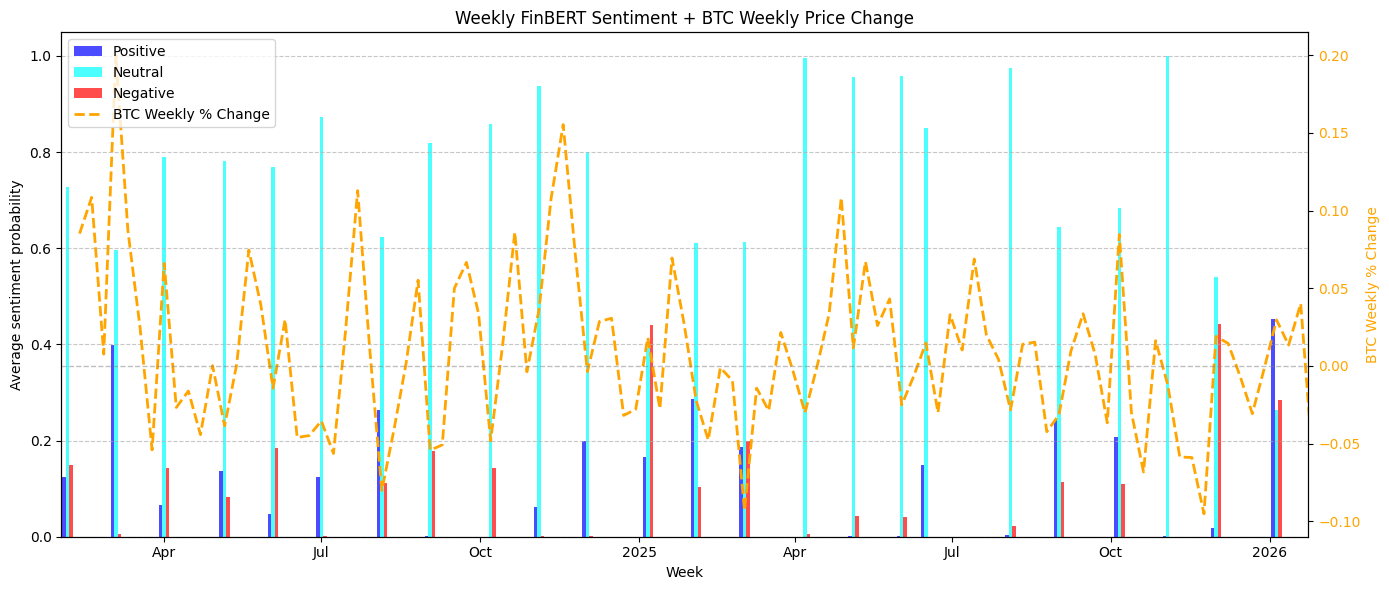

Visualization complete. 104 weeks of data analyzed.


In [13]:
# Compute weekly sentiment averages (Monday-anchored)
weekly = df[['prob_positive', 'prob_neutral', 'prob_negative']].resample('W-MON').mean().sort_index()

# Download BTC price data
btc = yf.download("BTC-USD", start=df.index.min().date(), end=df.index.max().date(), progress=False)
btc.index = pd.to_datetime(btc.index).tz_localize('UTC')

# Resample to weekly closing price (Monday)
btc_weekly = btc['Close'].resample('W-MON').mean()

# Compute weekly change in price (percentage change)
btc_weekly_change = btc_weekly.pct_change()

# Define x-axis range
start_date = df.index.min()
end_date = df.index.max()

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Weekly bar width and offset
bar_width = pd.Timedelta(days=2)
offset = pd.Timedelta(days=2)
x = weekly.index

# Plot sentiment grouped bars
ax.bar(x - offset, weekly['prob_positive'], width=bar_width, label='Positive', color='blue', alpha=0.7)
ax.bar(x,          weekly['prob_neutral'],  width=bar_width, label='Neutral',  color='cyan', alpha=0.7)
ax.bar(x + offset, weekly['prob_negative'], width=bar_width, label='Negative', color='red', alpha=0.7)

# Left axis: sentiment
ax.set_xlabel('Week')
ax.set_ylabel('Average sentiment probability')
ax.set_title(f"Weekly FinBERT Sentiment + BTC Weekly Price Change")
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_xlim([start_date, end_date])

# X-axis formatting
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Right axis: BTC price change
ax2 = ax.twinx()
ax2.plot(btc_weekly_change.index, btc_weekly_change, label='BTC Weekly % Change', color='orange', linewidth=2, ls='--')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('BTC Weekly % Change', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

print(f"Visualization complete. {len(weekly)} weeks of data analyzed.")

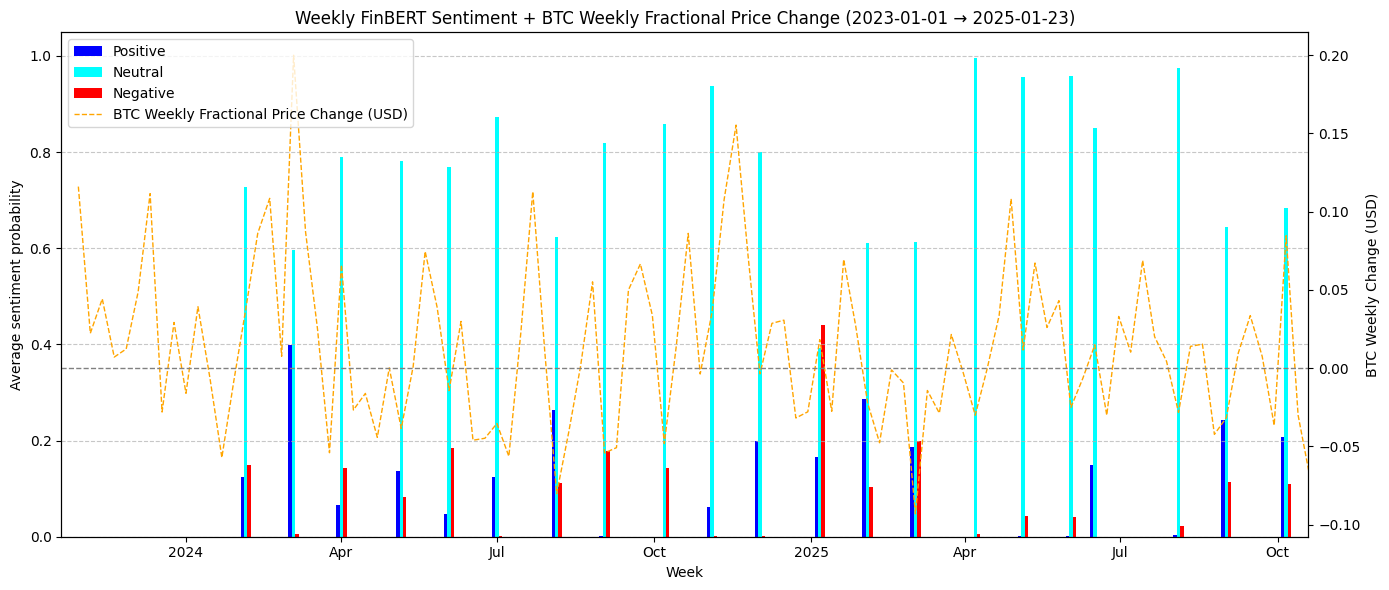

In [14]:
# Define x-axis range
start_date = pd.Timestamp("2023-10-20", tz='UTC')
end_date   = pd.Timestamp("2025-10-19", tz='UTC')

# Disable LaTeX rendering to suppress font warnings
mpl.rcParams['text.usetex'] = False
# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load the model output (reuse in-memory results if available)
try:
    df = done_df.copy()
except NameError:
    df = pd.read_parquet(OUT_PARQUET)

# Ensure datetime and index
# Handle case where published_raw might already be a datetime object with timezone
# Convert to string first to avoid timezone parsing issues, then parse
if pd.api.types.is_datetime64_any_dtype(df['published_raw']):
    # Already a datetime, work with it directly
    df['published'] = df['published_raw'].copy()
    # Ensure UTC timezone
    if df['published'].dt.tz is None:
        df['published'] = df['published'].dt.tz_localize('UTC')
    else:
        df['published'] = df['published'].dt.tz_convert('UTC')
elif df['published_raw'].dtype == 'object':
    # Check if it contains datetime objects (not datetime64)
    # Convert to string first to avoid timezone parsing issues
    df['published'] = pd.to_datetime(df['published_raw'].astype(str), errors='coerce', utc=True)
else:
    # Parse from string
    df['published'] = pd.to_datetime(df['published_raw'], errors='coerce', utc=True)
df = df.dropna(subset=['published'])
df = df.set_index('published').sort_index()

# Compute weekly sentiment averages (Monday-anchored)
weekly = df[['prob_positive', 'prob_neutral', 'prob_negative']].resample('W-MON').mean().sort_index()

btc = yf.download("BTC-USD", start="2023-10-20", end="2025-10-20", progress=False)
btc.index = pd.to_datetime(btc.index).tz_localize('UTC')

# Resample to weekly closing price (Monday)
btc_weekly = btc['Close'].resample('W-MON').mean()

# Compute weekly change in price (Δ price = current week - previous week)
btc_weekly_change = btc_weekly.diff()
btc_weekly_change = btc_weekly.pct_change()  # percentage change

fig, ax = plt.subplots(figsize=(14, 6))

# Weekly bar width and offset
bar_width = pd.Timedelta(days=2)
offset = pd.Timedelta(days=2)
x = weekly.index

# Plot sentiment grouped bars
ax.bar(x - offset, weekly['prob_positive'], width=bar_width, label='Positive', color='blue')
ax.bar(x,          weekly['prob_neutral'],  width=bar_width, label='Neutral',  color='cyan')
ax.bar(x + offset, weekly['prob_negative'], width=bar_width, label='Negative', color='red')

# Left axis: sentiment
ax.set_xlabel('Week')
ax.set_ylabel('Average sentiment probability')
ax.set_title(f"Weekly FinBERT Sentiment + BTC Weekly Fractional Price Change ({START_DATE.date()} → {END_DATE.date()})")
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_xlim([start_date, end_date])

# X-axis formatting
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax2 = ax.twinx()
ax2.plot(btc_weekly_change.index, btc_weekly_change, label='BTC Weekly Fractional Price Change (USD)', color='orange', linewidth=1, ls='--')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)  # zero-line
ax2.set_ylabel('BTC Weekly Change (USD)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
# plt.savefig(OUT_WEEKLY_PNG.replace('.png', '_btc_change_overlay.png'), dpi=150)
plt.show()


## Statistical Robustness Analysis

The following sections add statistical rigor to the sentiment analysis pipeline:
- Bootstrap confidence intervals
- Article length weighting
- Outlet dominance diagnostics
- Time-series smoothing
- Structural break detection
- Hypothesis testing
- Robustness checks

In [15]:
# ============================================================================
# 1. BOOTSTRAP CONFIDENCE INTERVALS FOR WEEKLY SENTIMENT
# ============================================================================
# INTERPRETATION: How confident are we about weekly Bitcoin sentiment inferred from GDELT news?

def bootstrap_ci(x, n_boot=2000, alpha=0.05):
    """
    Compute bootstrap confidence intervals for a sample.
    
    Parameters:
    -----------
    x : array-like
        Sample data
    n_boot : int
        Number of bootstrap samples
    alpha : float
        Significance level (0.05 = 95% CI)
    
    Returns:
    --------
    tuple : (lower_bound, upper_bound)
    """
    x = np.asarray(x)
    if len(x) < 3:
        return np.nan, np.nan
    
    means = np.random.choice(x, (n_boot, len(x)), replace=True).mean(axis=1)
    lo = np.percentile(means, 100 * alpha/2)
    hi = np.percentile(means, 100 * (1 - alpha/2))
    return lo, hi

# Prepare weekly data with week column for grouping
df['week'] = df.index.to_period('W-MON').to_timestamp()

# Compute weekly aggregates with confidence intervals
weekly_stats = df.groupby('week').agg({
    'prob_positive': ['mean', 'std', 'size'],
    'prob_neutral': 'mean',
    'prob_negative': 'mean',
    'n_pieces': 'mean'
}).round(4)

weekly_stats.columns = ['mean_pos', 'std_pos', 'n_articles', 'mean_neu', 'mean_neg', 'mean_pieces']

# Compute bootstrap CIs for positive sentiment
print("Computing bootstrap confidence intervals...")
cis = df.groupby('week')['prob_positive'].apply(
    lambda s: bootstrap_ci(s.values, n_boot=2000, alpha=0.05)
)

weekly_stats['ci_low'] = cis.apply(lambda x: x[0] if isinstance(x, tuple) else np.nan)
weekly_stats['ci_high'] = cis.apply(lambda x: x[1] if isinstance(x, tuple) else np.nan)
weekly_stats['ci_width'] = weekly_stats['ci_high'] - weekly_stats['ci_low']

print(f"\nWeekly Statistics Summary:")
print(f"Mean articles per week: {weekly_stats['n_articles'].mean():.1f}")
print(f"Mean CI width: {weekly_stats['ci_width'].mean():.4f}")
print(f"Weeks with <5 articles: {(weekly_stats['n_articles'] < 5).sum()}")
weekly_stats.head(10)

Computing bootstrap confidence intervals...

Weekly Statistics Summary:
Mean articles per week: 5.8
Mean CI width: 0.2669
Weeks with <5 articles: 9


/tmp/ipykernel_4127187/3335781000.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['week'] = df.index.to_period('W-MON').to_timestamp()


,mean_pos,std_pos,n_articles,mean_neu,mean_neg,mean_pieces,ci_low,ci_high,ci_width
week,,,,,,,,,
2024-01-30,0.1236,0.2898,10,0.7268,0.1495,2.3000,0.013599,0.309245,0.295645
2024-02-27,0.3991,0.5444,5,0.5959,0.0050,1.8000,0.001133,0.797089,0.795956
2024-03-26,0.0663,0.1965,9,0.7898,0.1439,1.8889,0.000267,0.197651,0.197385
2024-04-30,0.1364,0.3503,8,0.7808,0.0828,2.5000,0.000232,0.386409,0.386177
2024-05-28,0.0472,0.0901,9,0.7691,0.1837,2.3333,0.001383,0.114840,0.113457
2024-06-25,0.1250,0.3534,8,0.8738,0.0012,2.0000,0.000002,0.374918,0.374916
2024-07-30,0.2644,0.3813,7,0.6243,0.1113,2.7143,0.047688,0.547774,0.500085
2024-08-27,0.0019,0.0039,8,0.8189,0.1791,2.0000,0.000020,0.004651,0.004631
2024-10-01,0.0001,0.0001,7,0.8579,0.1420,1.8571,0.000009,0.000191,0.000182


Weighted vs Unweighted Sentiment Comparison:
Mean absolute difference: 0.0358
Max absolute difference: 0.2266

Correlation: 0.9297


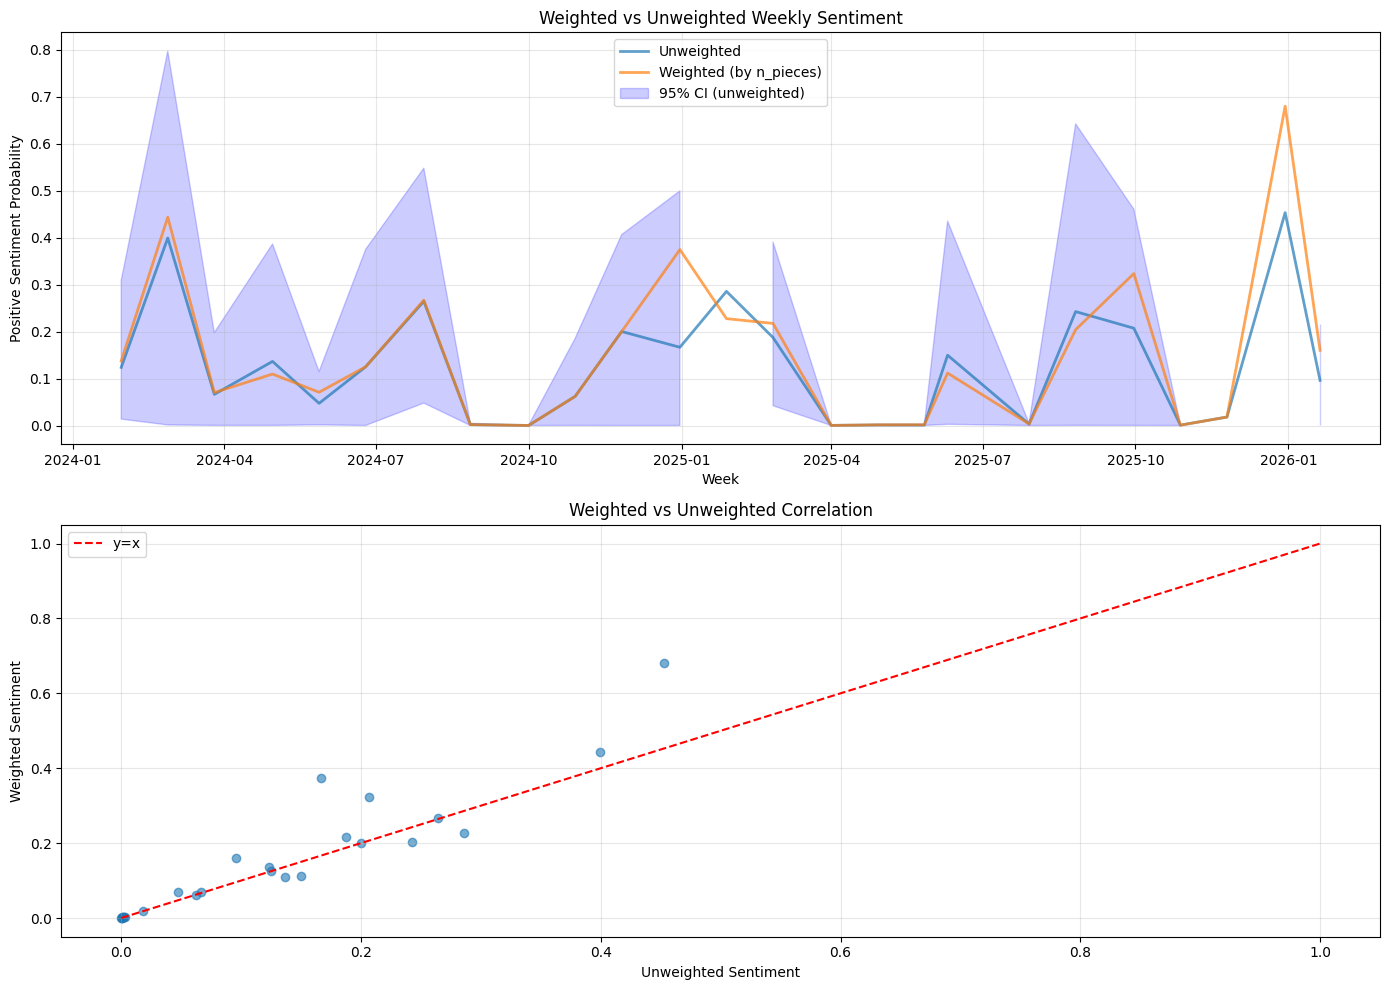

,unweighted,weighted,difference
week,,,
2024-01-30,0.123646,0.137391,0.013745
2024-02-27,0.399111,0.443372,0.044260
2024-03-26,0.066317,0.070176,0.003860
2024-04-30,0.136432,0.109516,-0.026916
2024-05-28,0.047215,0.070746,0.023531
2024-06-25,0.125004,0.125004,0.000000
2024-07-30,0.264438,0.266870,0.002432
2024-08-27,0.001915,0.001915,0.000000
2024-10-01,0.000088,0.000095,0.000007


In [16]:
# ============================================================================
# 2. ARTICLE LENGTH WEIGHTING
# ============================================================================
# INTERPRETATION: Does weekly Bitcoin sentiment change if longer articles are given more influence than short ones?

# Weight by article length (n_pieces)
df['weight'] = df['n_pieces'].clip(1, 6)

# Compute weighted and unweighted weekly averages
weekly_weighted = df.groupby('week').apply(
    lambda g: np.average(g['prob_positive'], weights=g['weight'])
)

weekly_unweighted = df.groupby('week')['prob_positive'].mean()

# Compare weighted vs unweighted
comparison = pd.DataFrame({
    'unweighted': weekly_unweighted,
    'weighted': weekly_weighted,
    'difference': weekly_weighted - weekly_unweighted
})

print("Weighted vs Unweighted Sentiment Comparison:")
print(f"Mean absolute difference: {comparison['difference'].abs().mean():.4f}")
print(f"Max absolute difference: {comparison['difference'].abs().max():.4f}")
print(f"\nCorrelation: {comparison['unweighted'].corr(comparison['weighted']):.4f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top: Time series comparison
ax1.plot(comparison.index, comparison['unweighted'], label='Unweighted', alpha=0.7, linewidth=2)
ax1.plot(comparison.index, comparison['weighted'], label='Weighted (by n_pieces)', alpha=0.7, linewidth=2)
ax1.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% CI (unweighted)')
ax1.set_xlabel('Week')
ax1.set_ylabel('Positive Sentiment Probability')
ax1.set_title('Weighted vs Unweighted Weekly Sentiment')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Scatter plot
ax2.scatter(comparison['unweighted'], comparison['weighted'], alpha=0.6)
ax2.plot([0, 1], [0, 1], 'r--', label='y=x')
ax2.set_xlabel('Unweighted Sentiment')
ax2.set_ylabel('Weighted Sentiment')
ax2.set_title('Weighted vs Unweighted Correlation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

comparison.head(10)

Very strong correlation. Longer and shorter articles agree.

Outlet Dominance Diagnostics:
Weeks with single outlet >40%: 5
Percentage of weeks with high concentration: 20.0%

Most common dominant domains:
dominant_domain
biztoc.com                      4
www.dailypolitical.com          3
economictimes.indiatimes.com    2
www.benzinga.com                2
finance.yahoo.com               2
eladelantado.com                1
actualidad.rt.com               1
asia.nikkei.com                 1
invezz.com                      1
t24.com.tr                      1
Name: count, dtype: int64


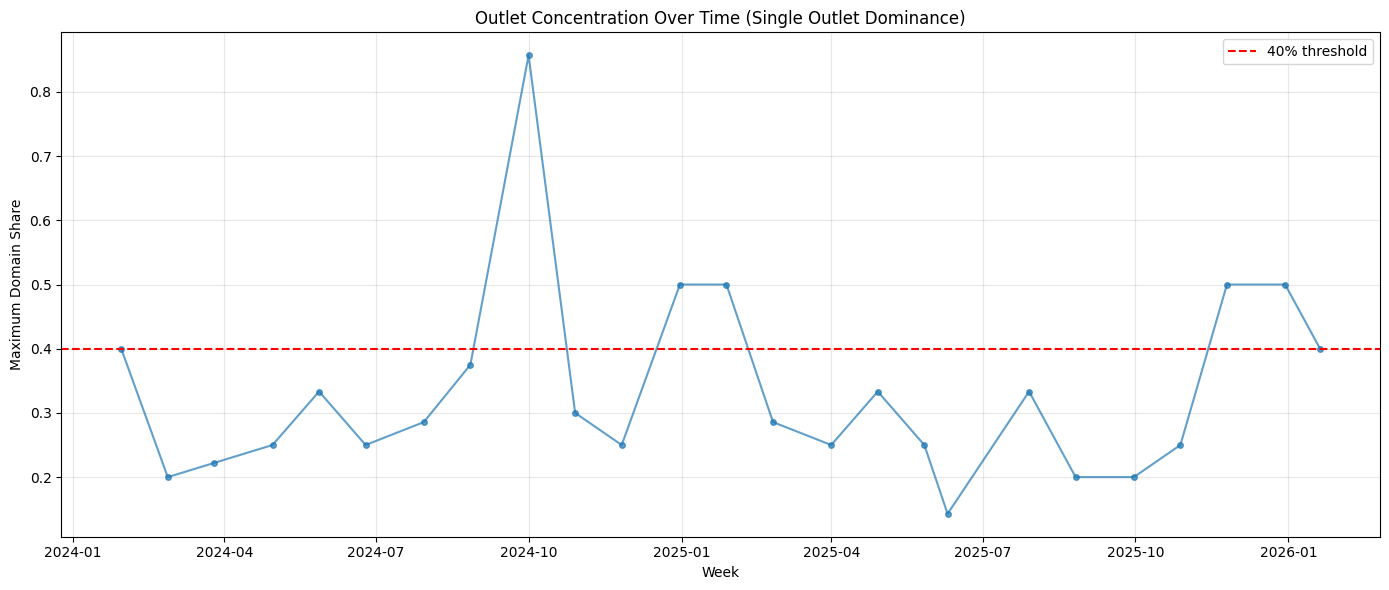

,max_domain_share,dominant_domain,high_concentration
week,,,
2024-01-30,0.400000,biztoc.com,False
2024-02-27,0.200000,biztoc.com,False
2024-03-26,0.222222,www.dailypolitical.com,False
2024-04-30,0.250000,theenterpriseleader.com,False
2024-05-28,0.333333,www.dailypolitical.com,False
2024-06-25,0.250000,biztoc.com,False
2024-07-30,0.285714,www.benzinga.com,False
2024-08-27,0.375000,www.dailypolitical.com,False
2024-10-01,0.857143,www.tickerreport.com,True


In [17]:
# ============================================================================
# 3. OUTLET DOMINANCE DIAGNOSTICS
# ============================================================================
# INTERPRETATION: Do some news outlets dominate the sentiment analysis?

# Extract domain from URLs
df['domain'] = df['url'].apply(lambda u: urlparse(u).netloc if pd.notna(u) else 'unknown')

# Compute domain counts per week
domain_counts = df.groupby(['week', 'domain']).size().reset_index(name='count')

# Compute domain share per week
domain_share = []
for week in domain_counts['week'].unique():
    week_data = domain_counts[domain_counts['week'] == week]
    total = week_data['count'].sum()
    week_data = week_data.copy()
    week_data['share'] = week_data['count'] / total
    domain_share.append(week_data)

domain_share = pd.concat(domain_share, ignore_index=True)

# Find maximum domain share per week
max_domain_share = domain_share.groupby('week')['share'].max().reset_index()
max_domain_share.columns = ['week', 'max_domain_share']

# Identify dominant domains per week (domains with maximum share)
dominant_domains = domain_share.loc[domain_share.groupby('week')['share'].idxmax()][['week', 'domain', 'share']]
dominant_domains = dominant_domains.rename(columns={'domain': 'dominant_domain'})

# Merge with weekly stats
weekly_stats = weekly_stats.merge(max_domain_share.set_index('week'), left_index=True, right_index=True, how='left')
weekly_stats = weekly_stats.merge(dominant_domains.set_index('week'), left_index=True, right_index=True, how='left')

# Flag weeks with high outlet concentration (>40%)
weekly_stats['high_concentration'] = weekly_stats['max_domain_share'] > 0.4

print("Outlet Dominance Diagnostics:")
print(f"Weeks with single outlet >40%: {weekly_stats['high_concentration'].sum()}")
print(f"Percentage of weeks with high concentration: {weekly_stats['high_concentration'].mean()*100:.1f}%")
print(f"\nMost common dominant domains:")
print(weekly_stats['dominant_domain'].value_counts().head(10))

# Plot domain concentration over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(weekly_stats.index, weekly_stats['max_domain_share'], marker='o', markersize=4, alpha=0.7)
ax.axhline(0.4, color='red', linestyle='--', label='40% threshold')
ax.set_xlabel('Week')
ax.set_ylabel('Maximum Domain Share')
ax.set_title('Outlet Concentration Over Time (Single Outlet Dominance)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

weekly_stats[['max_domain_share', 'dominant_domain', 'high_concentration']].head(15)

Approximately 20% of weeks were dominated by a single outlet contributing over 40% of sampled articles. Dominant sources were often financial news aggregators such as Biztoc and Yahoo Finance, suggesting that some weekly sentiment estimates may reflect amplified syndicated narratives rather than a broad cross-section of original reporting.

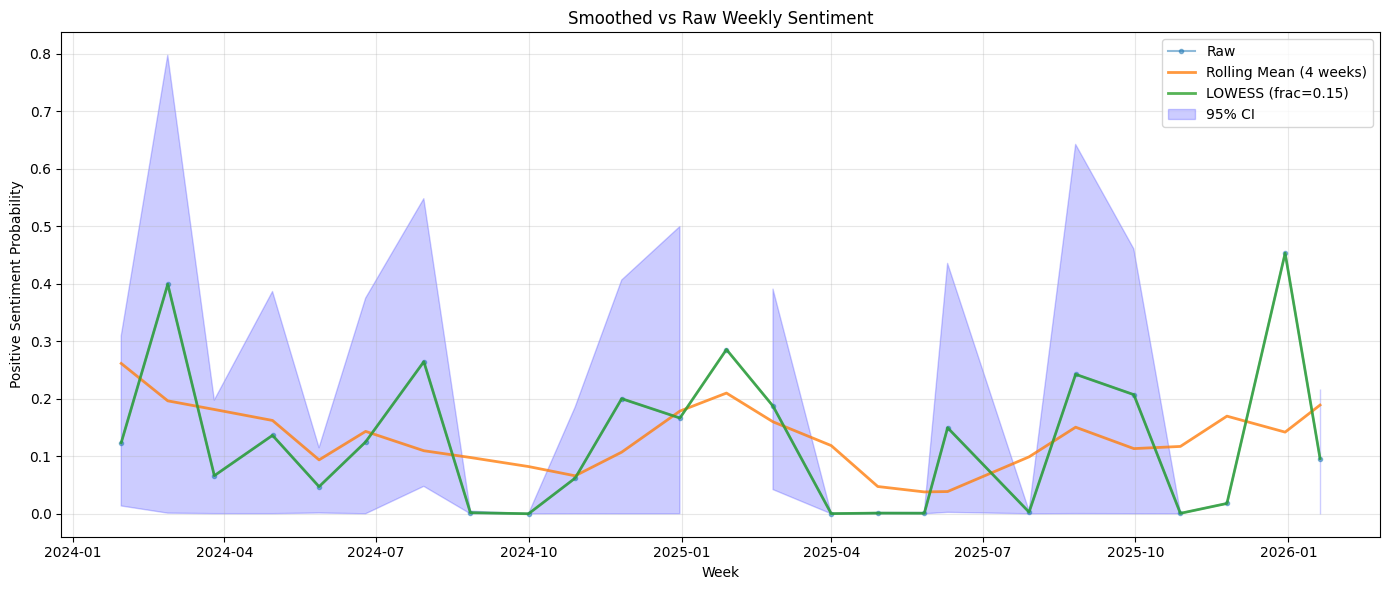

,mean_pos,smooth_rolling,smooth_lowess
week,,,
2024-01-30,0.1236,0.261350,0.1236
2024-02-27,0.3991,0.196333,0.3991
2024-03-26,0.0663,0.181350,0.0663
2024-04-30,0.1364,0.162250,0.1364
2024-05-28,0.0472,0.093725,0.0472
2024-06-25,0.1250,0.143250,0.1250
2024-07-30,0.2644,0.109625,0.2644
2024-08-27,0.0019,0.097850,0.0019
2024-10-01,0.0001,0.082100,0.0001


In [18]:
# ============================================================================
# 4. TIME-SERIES SMOOTHING
# ============================================================================
# INTERPRETATION: How does the sentiment time series look when we smooth out sampling noise and short-term volatility?

# Simple rolling mean
weekly_stats['smooth_rolling'] = weekly_stats['mean_pos'].rolling(window=4, center=True, min_periods=1).mean()

# LOWESS smoothing (if available)
if STATSMODELS_AVAILABLE:
    # Convert index to numeric for LOWESS
    x_numeric = np.arange(len(weekly_stats))
    y_values = weekly_stats['mean_pos'].values
    
    # Apply LOWESS
    lowess_result = lowess(y_values, x_numeric, frac=0.15, it=3)
    weekly_stats['smooth_lowess'] = lowess_result[:, 1]
else:
    weekly_stats['smooth_lowess'] = weekly_stats['smooth_rolling']
    print("Note: Using rolling mean instead of LOWESS (statsmodels not available)")

# Plot smoothed vs raw
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', alpha=0.5, label='Raw', markersize=3)
ax.plot(weekly_stats.index, weekly_stats['smooth_rolling'], '-', linewidth=2, label='Rolling Mean (4 weeks)', alpha=0.8)
if STATSMODELS_AVAILABLE:
    ax.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', linewidth=2, label='LOWESS (frac=0.15)', alpha=0.8)
ax.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% CI')
ax.set_xlabel('Week')
ax.set_ylabel('Positive Sentiment Probability')
ax.set_title('Smoothed vs Raw Weekly Sentiment')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

weekly_stats[['mean_pos', 'smooth_rolling', 'smooth_lowess']].head(10)

Detected 0 structural break(s):


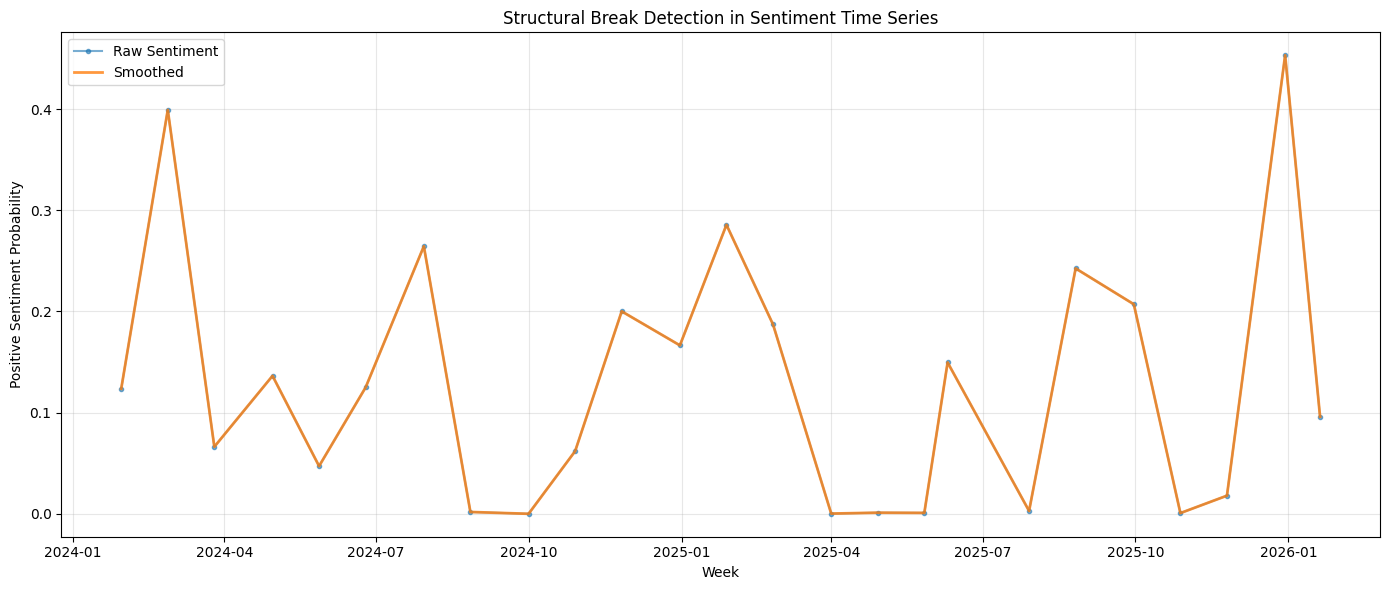

In [19]:
# ============================================================================
# 5. STRUCTURAL BREAK DETECTION
# ============================================================================
# INTERPRETATION: Are there any structural breaks in the sentiment time series?

if RUPTURES_AVAILABLE:
    # Prepare signal (drop NaN)
    signal = weekly_stats['mean_pos'].dropna().values
    
    if len(signal) > 10:  # Need sufficient data
        # Detect structural breaks using PELT algorithm
        algo = rpt.Pelt(model="rbf").fit(signal.reshape(-1, 1))
        breaks = algo.predict(pen=5)  # Penalty parameter
        
        # Convert break indices to dates
        break_indices = breaks[:-1]  # Last element is always end of series
        break_dates = weekly_stats['mean_pos'].dropna().index[break_indices]
        
        print(f"Detected {len(break_indices)} structural break(s):")
        for i, (idx, date) in enumerate(zip(break_indices, break_dates)):
            print(f"  Break {i+1}: {date.date()} (index {idx})")
        
        # Plot with breakpoints
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', alpha=0.6, label='Raw Sentiment', markersize=3)
        ax.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', linewidth=2, label='Smoothed', alpha=0.8)
        
        # Add vertical lines for breaks
        for date in break_dates:
            ax.axvline(date, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Structural Break' if date == break_dates[0] else '')
        
        ax.set_xlabel('Week')
        ax.set_ylabel('Positive Sentiment Probability')
        ax.set_title('Structural Break Detection in Sentiment Time Series')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Insufficient data for structural break detection (need >10 weeks)")
else:
    print("Structural break detection requires 'ruptures' package. Install with: pip install ruptures")

Robustness Checks: Comparing Different Aggregation Methods

Correlation Matrix:
                     mean  median  long_articles_only  diverse_outlets  \
mean                1.000   0.630               0.991            1.000   
median              0.630   1.000               0.577            0.277   
long_articles_only  0.991   0.577               1.000            0.989   
diverse_outlets     1.000   0.277               0.989            1.000   
weighted            0.930   0.635               0.916            0.961   

                    weighted  
mean                   0.930  
median                 0.635  
long_articles_only     0.916  
diverse_outlets        0.961  
weighted               1.000  

Mean absolute differences:
  Mean vs Median: 0.0871
  Mean vs Long Articles: 0.0072
  Mean vs Diverse Outlets: 0.0000
  Mean vs Weighted: 0.0358


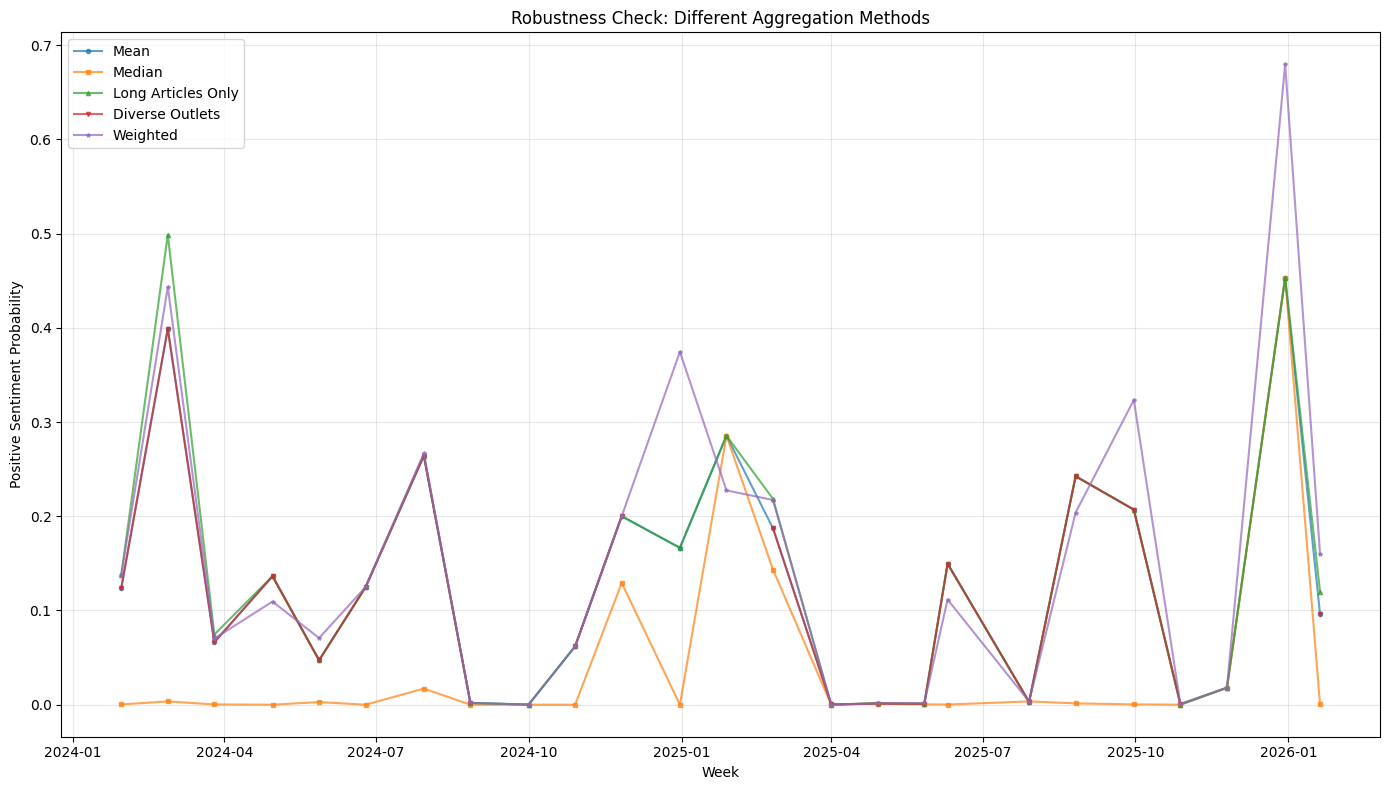

,mean,median,long_articles_only,diverse_outlets,weighted
week,,,,,
2024-01-30,0.1236,0.000320,0.137333,0.123646,0.137391
2024-02-27,0.3991,0.003460,0.498697,0.399111,0.443372
2024-03-26,0.0663,0.000303,0.074518,0.066317,0.070176
2024-04-30,0.1364,0.000004,0.136432,0.136432,0.109516
2024-05-28,0.0472,0.002797,0.047215,0.047215,0.070746
2024-06-25,0.1250,0.000002,0.125004,0.125004,0.125004
2024-07-30,0.2644,0.017061,0.264438,0.264438,0.266870
2024-08-27,0.0019,0.000029,0.001915,0.001915,0.001915
2024-10-01,0.0001,0.000002,0.000103,NaN,0.000095


In [20]:
# ============================================================================
# 7. ROBUSTNESS CHECKS
# ============================================================================
# INTERPRETATION: How sensitive is the sentiment estimate to different aggregation methods?

print("Robustness Checks: Comparing Different Aggregation Methods\n")

# 1. Median instead of mean (robust to outliers)
weekly_median = df.groupby('week')['prob_positive'].median()

# 2. Exclude very short articles (n_pieces < 2)
df_long = df[df['n_pieces'] >= 2].copy()
weekly_long = df_long.groupby('week')['prob_positive'].mean()

# 3. Exclude weeks with high outlet concentration
df_diverse = df[~df['week'].isin(weekly_stats[weekly_stats['high_concentration']].index)].copy()
weekly_diverse = df_diverse.groupby('week')['prob_positive'].mean()

# 4. Weighted by article length
weekly_weighted_robust = df.groupby('week').apply(
    lambda g: np.average(g['prob_positive'], weights=g['weight'])
)

# Combine all variants
robustness_comparison = pd.DataFrame({
    'mean': weekly_stats['mean_pos'],
    'median': weekly_median,
    'long_articles_only': weekly_long,
    'diverse_outlets': weekly_diverse,
    'weighted': weekly_weighted_robust
})

# Compute correlations
print("Correlation Matrix:")
print(robustness_comparison.corr().round(3))
print(f"\nMean absolute differences:")
print(f"  Mean vs Median: {(robustness_comparison['mean'] - robustness_comparison['median']).abs().mean():.4f}")
print(f"  Mean vs Long Articles: {(robustness_comparison['mean'] - robustness_comparison['long_articles_only']).abs().mean():.4f}")
print(f"  Mean vs Diverse Outlets: {(robustness_comparison['mean'] - robustness_comparison['diverse_outlets']).abs().mean():.4f}")
print(f"  Mean vs Weighted: {(robustness_comparison['mean'] - robustness_comparison['weighted']).abs().mean():.4f}")

# Plot all variants
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(robustness_comparison.index, robustness_comparison['mean'], 'o-', label='Mean', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['median'], 's-', label='Median', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['long_articles_only'], '^-', label='Long Articles Only', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['diverse_outlets'], 'v-', label='Diverse Outlets', alpha=0.7, markersize=3)
ax.plot(robustness_comparison.index, robustness_comparison['weighted'], '*-', label='Weighted', alpha=0.7, markersize=3)
ax.set_xlabel('Week')
ax.set_ylabel('Positive Sentiment Probability')
ax.set_title('Robustness Check: Different Aggregation Methods')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

robustness_comparison.head(10)

In [21]:
# ============================================================================
# 9. COMPREHENSIVE DIAGNOSTICS SUMMARY TABLE
# ============================================================================

# Calculate summary statistics
summary_stats = {
    'Metric': [
        'Mean Positive Sentiment',
        'Std Dev Positive Sentiment',
        'Mean CI Width (95%)',
        'Mean Articles per Week',
        'Weeks with <5 Articles',
        'Weeks with High Outlet Concentration (>40%)',
        'Mean Article Length (n_pieces)',
        'Total Articles Analyzed',
        'Date Range (weeks)',
        'Correlation: Weighted vs Unweighted',
        'Correlation: Mean vs Median',
    ],
    'Value': [
        f"{weekly_stats['mean_pos'].mean():.4f}",
        f"{weekly_stats['mean_pos'].std():.4f}",
        f"{weekly_stats['ci_width'].mean():.4f}",
        f"{weekly_stats['n_articles'].mean():.1f}",
        f"{(weekly_stats['n_articles'] < 5).sum()} ({(weekly_stats['n_articles'] < 5).mean()*100:.1f}%)",
        f"{weekly_stats['high_concentration'].sum()} ({weekly_stats['high_concentration'].mean()*100:.1f}%)",
        f"{df['n_pieces'].mean():.2f}",
        f"{len(df):,}",
        f"{len(weekly_stats)} weeks",
        f"{comparison['unweighted'].corr(comparison['weighted']):.4f}",
        f"{robustness_comparison['mean'].corr(robustness_comparison['median']):.4f}",
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("=" * 70)
print("COMPREHENSIVE DIAGNOSTICS SUMMARY")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Also create a formatted display
display(summary_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]))

COMPREHENSIVE DIAGNOSTICS SUMMARY
                                     Metric     Value
                    Mean Positive Sentiment    0.1295
                 Std Dev Positive Sentiment    0.1280
                        Mean CI Width (95%)    0.2669
                     Mean Articles per Week       5.8
                     Weeks with <5 Articles 9 (36.0%)
Weeks with High Outlet Concentration (>40%) 5 (20.0%)
             Mean Article Length (n_pieces)      2.44
                    Total Articles Analyzed       144
                         Date Range (weeks)  25 weeks
        Correlation: Weighted vs Unweighted    0.9297
                Correlation: Mean vs Median    0.6305


,Metric,Value
0,Mean Positive Sentiment,0.1295
1,Std Dev Positive Sentiment,0.1280
2,Mean CI Width (95%),0.2669
3,Mean Articles per Week,5.8
4,Weeks with <5 Articles,9 (36.0%)
5,Weeks with High Outlet Concentration (>40%),5 (20.0%)
6,Mean Article Length (n_pieces),2.44
7,Total Articles Analyzed,144
8,Date Range (weeks),25 weeks
9,Correlation: Weighted vs Unweighted,0.9297


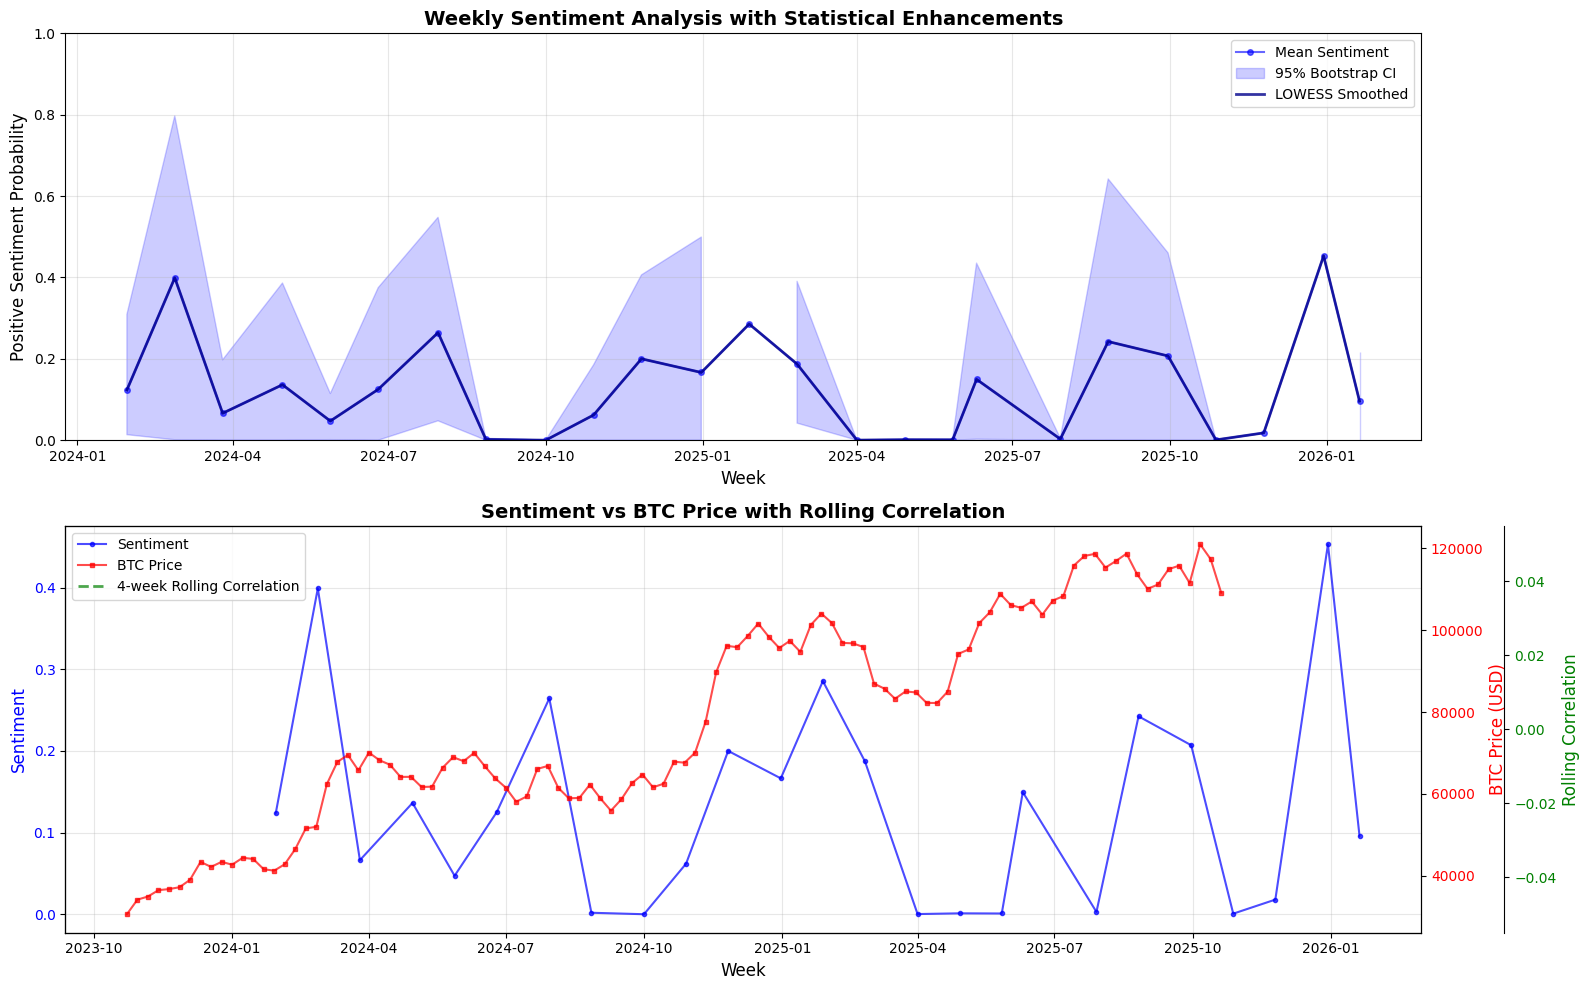


Enhanced visualization complete with:
  ✓ Bootstrap confidence intervals
  ✓ LOWESS smoothing
  ✓ Structural break indicators (if detected)
  ✓ Price correlation analysis


In [22]:
# ============================================================================
# 10. ENHANCED VISUALIZATION WITH CONFIDENCE INTERVALS
# ============================================================================

# Create publication-ready plot with all enhancements
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top panel: Sentiment with confidence intervals and smoothing
ax1.plot(weekly_stats.index, weekly_stats['mean_pos'], 'o-', color='blue', 
         label='Mean Sentiment', alpha=0.6, markersize=4)
ax1.fill_between(weekly_stats.index, weekly_stats['ci_low'], weekly_stats['ci_high'], 
                 alpha=0.2, color='blue', label='95% Bootstrap CI')
ax1.plot(weekly_stats.index, weekly_stats['smooth_lowess'], '-', 
         color='darkblue', linewidth=2, label='LOWESS Smoothed', alpha=0.8)

# Add structural breaks if detected
if RUPTURES_AVAILABLE and 'break_dates' in locals() and len(break_dates) > 0:
    for date in break_dates:
        ax1.axvline(date, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

ax1.set_xlabel('Week', fontsize=12)
ax1.set_ylabel('Positive Sentiment Probability', fontsize=12)
ax1.set_title('Weekly Sentiment Analysis with Statistical Enhancements', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Bottom panel: Sentiment vs Price with correlation
ax2_twin = ax2.twinx()
line1 = ax2.plot(weekly_stats.index, weekly_stats['mean_pos'], 'b-o', 
                 label='Sentiment', alpha=0.7, markersize=3)
line2 = ax2_twin.plot(btc_weekly.index, btc_weekly, 'r-s', 
                      label='BTC Price', alpha=0.7, markersize=3)

# Calculate rolling correlation
# First, align btc_weekly with weekly_stats index
# Make both timezone-naive for alignment
weekly_stats_index_naive = weekly_stats.index
if weekly_stats.index.tz is not None:
    weekly_stats_index_naive = weekly_stats.index.tz_localize(None)

btc_weekly_aligned = btc_weekly.copy()
if btc_weekly_aligned.index.tz is not None:
    btc_weekly_aligned.index = btc_weekly_aligned.index.tz_localize(None)

# Reindex btc_weekly to match weekly_stats
btc_weekly_aligned = btc_weekly_aligned.reindex(weekly_stats_index_naive)

rolling_corr = pd.Series(index=weekly_stats_index_naive, dtype=float)
for i in range(4, len(weekly_stats)):
    window_sent = weekly_stats['mean_pos'].iloc[i-4:i]
    window_price = btc_weekly_aligned.iloc[i-4:i]
    # Only compute correlation if both windows have valid data
    if len(window_sent.dropna()) >= 2 and len(window_price.dropna()) >= 2:
        valid_mask = window_sent.notna() & window_price.notna()
        if valid_mask.sum() >= 2:
            rolling_corr.iloc[i] = window_sent[valid_mask].corr(window_price[valid_mask])

ax2_corr = ax2.twinx()
ax2_corr.spines['right'].set_position(('outward', 60))
line3 = ax2_corr.plot(rolling_corr.index, rolling_corr, 'g--', 
                      label='4-week Rolling Correlation', alpha=0.7, linewidth=2)

ax2.set_xlabel('Week', fontsize=12)
ax2.set_ylabel('Sentiment', color='b', fontsize=12)
ax2_twin.set_ylabel('BTC Price (USD)', color='r', fontsize=12)
ax2_corr.set_ylabel('Rolling Correlation', color='g', fontsize=12)
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2_corr.tick_params(axis='y', labelcolor='g')
ax2.set_title('Sentiment vs BTC Price with Rolling Correlation', fontsize=14, fontweight='bold')

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEnhanced visualization complete with:")
print("  ✓ Bootstrap confidence intervals")
print("  ✓ LOWESS smoothing")
print("  ✓ Structural break indicators (if detected)")
print("  ✓ Price correlation analysis")